In [ ]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir("../..")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/soutrik-vm-dev/code/Users/Soutrik.Chowdhury/langgraph_ventures


#### In this noteboook we will discuss about the basics of langgraph and how to use it as discussed in the course DeepLearning.AI AI Agents in LangGraph

In [3]:
from src.utils import get_llm, get_embedder

In [4]:
llm_model = get_llm()
embedder_model = get_embedder()

In [5]:
# await llm_model.ainvoke("What is the capital of France?")

In [6]:
# await embedder_model.aembed_documents(["What is the capital of France?"])

In [5]:
import os
from tavily import TavilyClient

In [6]:
# connect
client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

In [7]:
# run search
result = client.search("What is in Nvidia's new Blackwell GPU?", include_answer=True)

# print the answer
print(result["answer"])

The new Blackwell GPU from Nvidia features the GB202, GB203, and GB205 GPUs, forming the backbone of the GeForce RTX 50 Series. The architecture includes fifth-generation Tensor Cores, fourth-generation RT Cores, and advanced technologies like DLSS 4, Reflex, DLSS Multi Frame Generation, and RTX Neural Shaders. The GeForce RTX 5090 is the most powerful GPU in the Blackwell family, followed by the RTX 5080 and RTX 5070.


In [69]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
import json

In [9]:
# We will go with one standard tool
tool = TavilySearchResults(max_results=4)  # increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [15]:
# first we will define agent state
class AgentState(TypedDict):
    """
    Agent state is a dictionary with the following keys:
    - messages: list[AnyMessage]
    """

    messages: Annotated[list[AnyMessage], operator.add]

In [17]:
agent_state = AgentState(messages="Hello, I am a chatbot")

In [18]:
agent_state

{'messages': 'Hello, I am a chatbot'}

In [71]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        # define the graph
        graph = StateGraph(state_schema=AgentState)
        # adding nodes
        graph.add_node(node="llm", action=self.call_openai)
        graph.add_node(node="action", action=self.take_action)
        # add conditional edges
        graph.add_conditional_edges(
            source="llm", path=self.exists_action, path_map={True: "action", False: END}
        )
        # feedback loop
        graph.add_edge(start_key="action", end_key="llm")
        # set the entry point
        graph.set_entry_point("llm")
        # compile the graph
        self.graph = graph.compile()

        # define the tools and bind them to the model
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        """
        Check if the last message has any tool calls and return True if it does and this will be used ine conditional edge to decide the next node
        """
        result = state["messages"][-1]  # gettting the last message
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        """
        Call the OpenAI model with the last message and return the response as a list of messages to be added to the state messages list
        """
        messages = state["messages"]
        if self.system:
            messages = [
                SystemMessage(content=self.system)
            ] + messages  # adding system message to the messages list
        messages = self.model.invoke(messages)
        return {"messages": [messages]}

    def take_action(self, state: AgentState):
        """
        Take action based on the tool calls in the last message and return the results as a list of messages to be added to the state messages list
        """
        tool_calls = state["messages"][-1].tool_calls
        # print(f"Tool calls: {tool_calls}")
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t["name"] in self.tools:  # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t["name"]].invoke(t["args"])
            results.append(
                ToolMessage(
                    tool_call_id=t["id"], name=t["name"], content=json.dumps(result)
                )
            )
        print("Back to the model!")
        return {"messages": results}

In [72]:
system_message = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

In [73]:
agent = Agent(model=llm_model, tools=[tool], system=system_message)

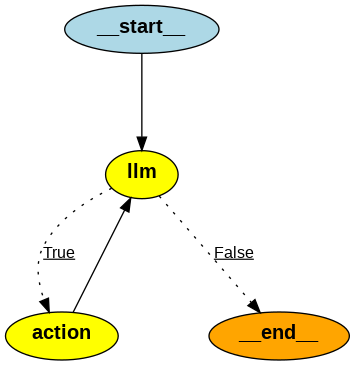

In [74]:
from IPython.display import Image

Image(agent.graph.get_graph().draw_png())

In [75]:
dir(agent.graph)

['InputType',
 'OutputType',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__ror__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abatch_with_config',
 '_abc_impl',
 '_acall_with_config',
 '_aprepare_state_snapshot',
 '_atransform_stream_with_config',
 '_batch_with_config',
 '_call_with_config',
 '_defaults',
 '_is_protocol',
 '_prepare_state_snapshot',
 '_repr_mimebundle_',
 '_transform_stream_with_config',
 'abatch',
 'abatch_as_completed',
 'aget_graph',
 'aget_state',
 'aget_state_history',
 'aget_subgraphs',
 'ainvoke',
 'as_tool',
 'assign',
 'astream',
 'astream_events',
 '

In [76]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = agent.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_NZVz1wewqGhk1u4N5hPxLvNo', 'type': 'tool_call'}
Back to the model!


In [86]:
from pprint import pprint

pprint(result["messages"][-1].content)

('The current weather in San Francisco is as follows:\n'
 '\n'
 '- **Temperature:** 13.3°C (55.9°F)\n'
 '- **Condition:** Light rain\n'
 '- **Wind:** 19.9 mph (32.0 kph) from the south\n'
 '- **Humidity:** 93%\n'
 '- **Cloud Cover:** 100%\n'
 '- **Feels Like:** 10.8°C (51.4°F)\n'
 '- **Visibility:** 11.0 km (6.0 miles)\n'
 '- **UV Index:** 0\n'
 '\n'
 'It is currently nighttime in San Francisco.')


In [88]:
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

In [89]:
result = agent.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'who won the Super Bowl 2024'}, 'id': 'call_3AAQ0R2WNVrVpk40Q1QFSZnI', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_JhBAXcTpqw9BlvorKyWISg3Q', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2024'}, 'id': 'call_xzRA11wpzMLabIXj90qJm7kH', 'type': 'tool_call'}
Back to the model!


In [90]:
from pprint import pprint

pprint(result["messages"][-1].content)

('1. **Who won the Super Bowl in 2024?**\n'
 '   - The Kansas City Chiefs won the Super Bowl in 2024, defeating the San '
 'Francisco 49ers 25-22.\n'
 '\n'
 "2. **In what state is the winning team's headquarters located?**\n"
 "   - The Kansas City Chiefs' headquarters is located in Kansas City, "
 'Missouri.\n'
 '\n'
 '3. **What is the GDP of that state?**\n'
 "   - The most recent data indicates that Missouri's GDP has shown solid "
 'growth in 2024. However, specific figures for the GDP in 2024 were not '
 'provided in the search results. For precise numbers, you may need to refer '
 'to detailed economic reports or databases such as those from the Bureau of '
 "Economic Analysis (BEA) or Missouri's economic reports.")


##### Next we will discuss about the state and HIL